# Pipeline de processamento dos dados FAMES
Lista de tarefas:
1. Definir canais a serem utilizados
1. Deadtime correction. Máximo deve ser de até uns 10 MHz, acima disso é dificil de corrigir
1. Background subtraction
1. Médias
1. Calculo de extinction rate aerosol com Klett e Raman combinado
1. Calculo backscattering para aerosol
1. Calculo mixing ratio metano/co2 para eficiencia de combustão
1. Calculo mixing ratio metano/n2 para concentração de metano
1. Calcula mixing ration co2/n2 para concentração de co2
1. TODO Precisa verificar se não tem crosstalk entre o 355 e 353
1. TODO Verificar influencia da fluorescencia


## Importa todos os pacotes de bibliotecas Python e da Biblioteca LIFA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import glob
import os
import math
from scipy.ndimage import gaussian_filter1d
import numpy as np
from importlib import reload

from lifa.licel import LicelLidarMeasurement
from lifa.processing import fit_checks; reload(fit_checks)
from lifa.processing import pre_processing; reload(pre_processing)
from lifa.processing import helper_functions
from lifa.processing import raman_mixing_ratio
from pathlib import Path
from datetime import datetime, timedelta
import string 

## Função de pré-processamento - converte o nome dos arquivos em datas

In [2]:
# ----------------------------
# Função para converter nome -> datetime
# ----------------------------
def parse_filename_time(fname):
    base = fname.split('.')[0]  # Ex: 'a24C0505'
    year = int('20' + base[1:3])
    month_char = base[3]
    if month_char in string.ascii_uppercase:  # A, B, C
        month = 9 + (ord(month_char) - ord('A') + 1)
    else:
        month = int(month_char)
    day = int(base[4:6])
    hour = int(base[6:8])
    ms_part = fname.split('.')[1]
    minute = int(ms_part[:2])
    second = int(ms_part[2:4])
    return datetime(year, month, day, hour, minute, second)

## Função de pré-processamento

In [3]:
def preprocess_signal(signal_dict, idx_min, idx_max, dead_time):
    processed = {}
    for key, val in signal_dict.items():
        profile = val.average_profile()
        if val.is_photon_counting:
            profile = pre_processing.correct_count_rate_dead_time_nonparalyzable(profile, dead_time)
        profile, _, _ = pre_processing.subtract_background(profile, idx_min, idx_max)
        processed[key] = profile
    return processed

## Parâmetros de entrada do processamento

In [10]:
#folder_path = Path('/home/fabio/venv/env_fames/lifa/notebooks/sample_data/20241204_CEPEMA_FLARE_acima_da_chama_p-23')
folder_path = Path(r'./sample_data/20241204_CEPEMA_FLARE_acima da chama_p=23')
dead_time = 1/240
idx_min = 15000
idx_max = 18000
start_idx = 30 #intervalo inicial de observação - antes do flare
end_idx = 200 #intervalo final de observação - após o flare

## Leitura e organização dos arquivos
## Agrupamento por intervalo temporal

In [17]:
# ----------------------------
# Lê e ordena arquivos
# ----------------------------
files = sorted([f for f in folder_path.iterdir() if f.is_file()])
file_times = [(f, parse_filename_time(f.name)) for f in files]
file_times.sort(key=lambda x: x[1])

# ----------------------------
# Agrupa por intervalos de 5 minutos
# ----------------------------
groups = []
current_group = []
current_start = None
interval = timedelta(minutes=5)

for f, t in file_times:
    if current_start is None:
        current_start = t
        current_group = [f]
    elif t - current_start < interval:
        current_group.append(f)
    else:
        groups.append(current_group)
        current_start = t
        current_group = [f]
if current_group:
    groups.append(current_group)

## Dicionário com informações dos canais de aquisição

In [18]:
# ----------------------------
# Dicionários de canais
# ----------------------------
upper_map = {
    'n2_raman_353': '00353.o_ph',
    'rayleigh_355': '00355.o_ph',
    'co2_raman_371': '00371.o_ph',
    'ch4_raman_395_s': '00395.s_ph',
    'ch4_raman_395_p': '00395.p_ph',
    'fluo_460': '00460.o_ph',
    'n2_raman_530': '00530.o_ph',
    'rayleigh_532': '00532.o_ph'
}
lower_map = {
    'n2_raman_353': '00353.o_an',
    'rayleigh_355': '00355.o_an',
    'co2_raman_371': '00371.o_an',
    'ch4_raman_395_s': '00395.s_an',
    'ch4_raman_395_p': '00395.p_an',
    'fluo_460': '00460.o_an',
    'n2_raman_530': '00530.o_an',
    'rayleigh_532': '00532.o_an'
}


## Processamento dos dados por grupo - considerando o intervalo temporal escolhido

In [19]:
# ----------------------------
# Processa cada grupo
# ----------------------------
results = {}  # Armazena resultados por intervalo

for i, group_files in enumerate(groups, 1):
    print(f"Processando grupo {i} ({len(group_files)} arquivos)...")
    
    # Cria medição para o grupo
    measurements = LicelLidarMeasurement(group_files)
    z = measurements.channels['00355.o_an'].z
    
    # Extrai sinais
    upper_signal = {name: measurements.channels[ch] for name, ch in upper_map.items()}
    lower_signal = {name: measurements.channels[ch] for name, ch in lower_map.items()}
    
    # Pré-processamento
    lower_processed = preprocess_signal(lower_signal, idx_min, idx_max, dead_time)
    upper_processed = preprocess_signal(upper_signal, idx_min, idx_max, dead_time)
    
    # Escolhe sinais e aplica bin shift
    signal = {}
    bin_shifts = {
        'co2_raman_371': (upper_processed, 4),
        'ch4_raman_395_s': (upper_processed, 4),
        'ch4_raman_395_p': (upper_processed, 4),
        'fluo_460': (lower_processed, 1)
    }
    for key in ['n2_raman_353', 'rayleigh_355', 'n2_raman_530', 'rayleigh_532']:
        signal[key] = lower_processed[key]
    for key, (source_dict, shift) in bin_shifts.items():
        signal[key] = pre_processing.correct_trigger_delay_bins(source_dict[key], shift)
    
    # Intervalo de interesse
    signal_interval = {key: data[start_idx:end_idx] for key, data in signal.items()}
    z_interval = z[start_idx:end_idx]
    
    # Posição do flare
    flare_pos = z[helper_functions.find_nearest(402, z)]
    
    # Armazena resultados
    results[i] = {
        'signal_interval': signal_interval,
        'z_interval': z_interval,
        'flare_pos': flare_pos,
        'files': [f.name for f in group_files]
    }

print("Processamento concluído!")

Processando grupo 1 (8 arquivos)...
Processando grupo 2 (8 arquivos)...
Processando grupo 3 (2 arquivos)...
Processamento concluído!


In [38]:
results.keys()

dict_keys([1, 2, 3])

## Configuração de visualização de legenda e cores dos gráficos - sinais de RCS 

In [20]:
# --- Configurações de legenda, cores e markers ---
# --- Legendas dos sinais ---
legend_labels = {
    'co2_raman_371': 'CO$_{2}$ at 371 nm',
    'ch4_raman_395_s': 'CH$_{4}$ s-pol at 395 nm',
    'ch4_raman_395_p': 'CH$_{4}$ p-pol at 395 nm',
    'fluo_460': 'Fluorescence at 460 nm',
    'n2_raman_353': 'N$_{2}$ at 353 nm',
    'rayleigh_355': 'Particulate signal at 355 nm',
    'n2_raman_530': 'N$_{2}$ at 530 nm',
    'rayleigh_532': 'Particulate signal at 532 nm'
}

# --- Cores dos sinais ---
colors = {
    'co2_raman_371': '#6a0dad',       # violeta
    'ch4_raman_395_s': '#7f00ff',     # roxo
    'ch4_raman_395_p': '#9b30ff',     # roxo claro
    'fluo_460': '#1f77b4',   # azul
    'n2_raman_353': '#4b0082',        # índigo
    'rayleigh_355': '#8a2be2', # azul-violeta
    'n2_raman_530': '#2ca02c',        # verde
    'rayleigh_532': '#3cb371'  # verde-claro
}

# --- Markers dos sinais ---
markers = {
    'co2_raman_371': 'o',       
    'ch4_raman_395_s': 'o',     
    'ch4_raman_395_p': 'o',     
    'fluo_460': 'o',   
    'n2_raman_353': 'o',        
    'rayleigh_355': 'o', 
    'n2_raman_530': 'o',        
    'rayleigh_532': 'o'  
}

# Plot dos sinais para monitoramento do Flare

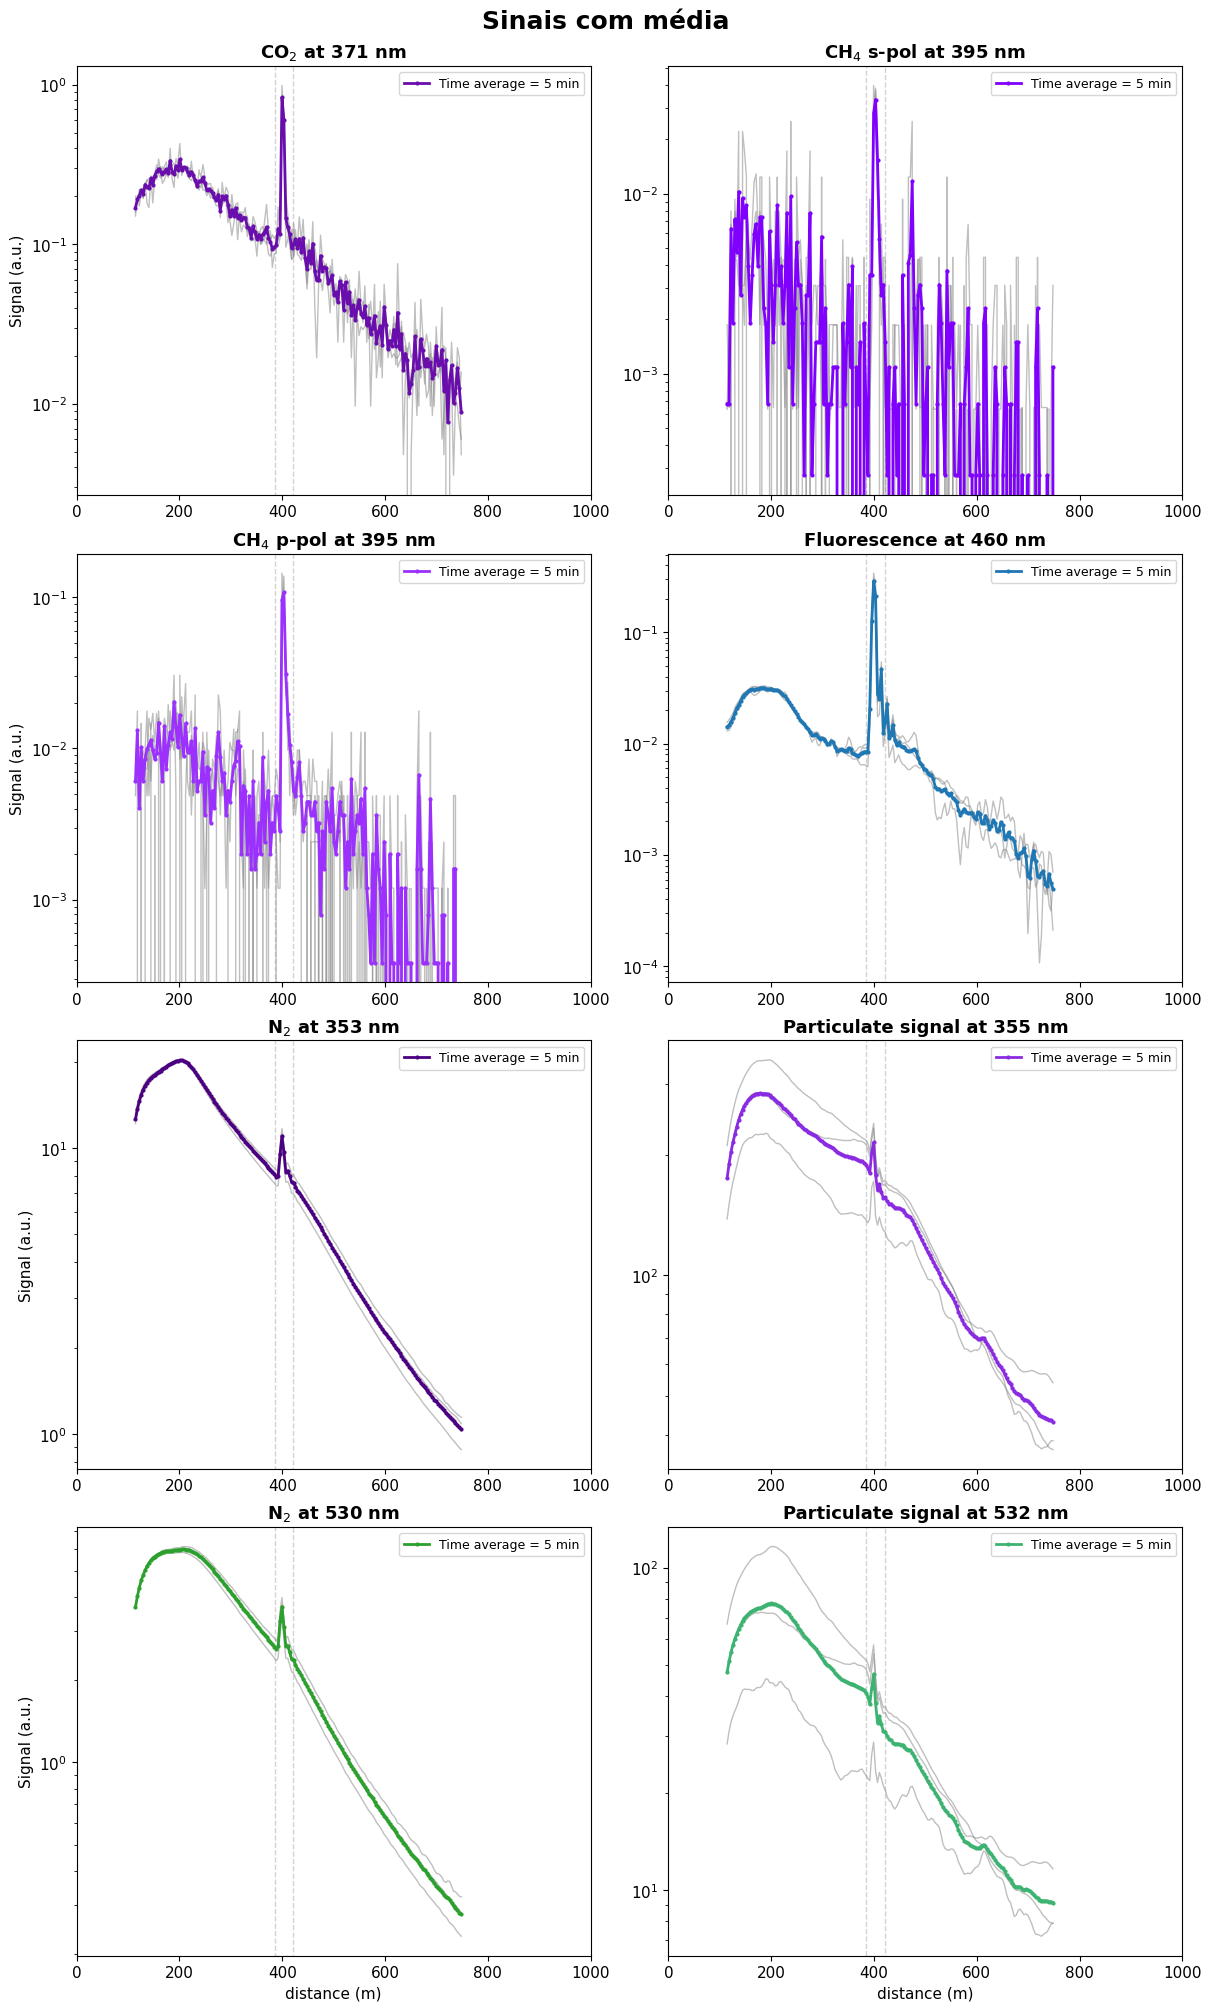

In [21]:
markers = {k:'o' for k in legend_labels.keys()}

# --- Controle de plotagem ---
plot_groups = True  # True = plot grupos + média, False = média apenas


# --- Criação do painel 4x2 ---
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(12, 20), layout='constrained')
ax = ax.flatten()

fig.suptitle('Sinais com média', fontsize=18, fontweight='bold')

delta = 18
title_fontsize = 13
label_fontsize = 11
tick_fontsize = 11

nrows, ncols = 4, 2  # para referência das posições

for i, key in enumerate(legend_labels.keys()):
    ax_i = ax[i]
    all_data = []

    # --- Plot dos grupos ---
    for j, (group_id, res) in enumerate(results.items()):
        signal_interval = res['signal_interval']
        z_interval = res['z_interval']
        flare_pos = res['flare_pos']

        data = signal_interval[key]
        all_data.append(data)

        if plot_groups:
            ax_i.plot(
                z_interval,
                data,
                color='gray',  # cor neutra para todos os grupos
                linestyle='-',
                linewidth=1.0,
                alpha=0.5
            )

    # --- Calcula a média do sinal ---
    mean_signal = np.mean(np.array(all_data), axis=0)

    # --- Plot da média ---
    mean_color = colors.get(key, 'k')
    marker = markers.get(key, 'o')
    ax_i.plot(
        z_interval,
        mean_signal,
        color=mean_color,
        linestyle='-',
        linewidth=2.0,
        marker=marker,
        markersize=2,
        label=f'Time average = {interval.seconds//60} min'
    )

    # Retângulo em torno do flare
    ax_i.axvspan(
        flare_pos - delta, flare_pos + delta,
        facecolor='none',
        edgecolor='lightgray',
        linestyle='--',
        linewidth=1.0
    )

    ax_i.set_title(legend_labels[key], fontsize=title_fontsize, fontweight='bold')


    # --- Ajuste dos labels ---
    col_idx = i % ncols
    row_idx = i // ncols

    if col_idx == 0:  # primeira coluna
        ax_i.set_ylabel('Signal (a.u.)', fontsize=label_fontsize)
    if row_idx == nrows - 1:  # última linha
        ax_i.set_xlabel('distance (m)', fontsize=label_fontsize)


    ax_i.set_yscale('log')
    ax_i.set_xlim(0, 1000)
    ax_i.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax_i.legend(fontsize=9)

# Desliga eixos extras
for j in range(i + 1, len(ax)):
    ax[j].axis('off')

plt.show()

# Cálculo da Razão de mistura (Mixing Ratio)

### Parâmetros iniciais

In [47]:
elevation_angle = 10.3
elevation = 0
bin_min = helper_functions.find_nearest(z, 300)
bin_max = helper_functions.find_nearest(z, 600)
delta = 18  # faixa do flare
interval = timedelta(minutes=5)  # intervalo temporal

plot_groups_concentration = True  # True = grupos + média, False = média apenas

# Dicionários para armazenar resultados
group_mratios = {}

## Processamento do Mixing Ratio e cálcula da Eficiência de queima

In [48]:
# --- Processamento por grupo ---
for group_id, res in results.items():
    signal_interval = res['signal_interval']
    z_interval = res['z_interval']
    flare_pos = res['flare_pos']
    
    # Range correction
    signal_rc = {key: pre_processing.apply_range_correction(val, z_interval) 
                 for key, val in signal_interval.items()}
    
    # Altura considerando ângulo de elevação
    height = z_interval * math.sin(math.radians(elevation_angle)) + elevation
    
    # Modelo Padrão Atmosfera
    pressure, temperature, density = helper_functions.standard_atmosphere(height)
    
    alpha_aer = np.zeros_like(height)
    
    # Mixing ratios
    co2_calib = 25000
    ch4_calib = 4000
    ce_calib = 0.25

    # Mixing ratio for CO2
    co2_mr = raman_mixing_ratio.raman_mixing_ratio(
        signal_rc['co2_raman_371'], signal_rc['n2_raman_353'], 
        3.75, alpha_aer, co2_calib, 371, 353, pressure, temperature)

    #Mixing ratio for CH4
    ch4_mr = raman_mixing_ratio.raman_mixing_ratio(
        signal_rc['ch4_raman_395_p'], signal_rc['n2_raman_353'], 
        3.75, alpha_aer, ch4_calib, 395, 353, pressure, temperature)

    # Eficiência de queima - CE
    ce_mr = raman_mixing_ratio.raman_mixing_ratio(
        signal_rc['ch4_raman_395_p'], signal_rc['co2_raman_371'], 
        3.75, alpha_aer, ce_calib, 395, 371, pressure, temperature)
    
    ce = 1/(1 + ce_mr) * 100


    # Recorte dos dados
    z_rec = z_interval[30:200]
    mratios_rec = {
        'CO2/N2': co2_mr[30:200],
        'CH4/N2': ch4_mr[30:200],
        'CE [%]': ce[30:200]
    }
    
    group_mratios[group_id] = {
        'z_interval': z_rec,
        'flare_pos': flare_pos,
        'mratios': mratios_rec
    }

## Recorte dos dados - cálculo das médias por grupos em intervalos temporais

In [49]:
# --- Calcula média de todos os grupos ---
mean_mratios = {}
for key in ['CO2/N2', 'CH4/N2', 'CE [%]']:
    stacked = np.array([g['mratios'][key] for g in group_mratios.values()])
    mean_mratios[key] = np.mean(stacked, axis=0)

z_interval_mean = group_mratios[list(group_mratios.keys())[0]]['z_interval']
flare_pos_mean = group_mratios[list(group_mratios.keys())[0]]['flare_pos']

## Configuração de visualização de legenda e cores dos gráficos - sinais de Mixing Ratio 

In [50]:
# --- Labels e cores ---
legend_labels = {
    'CO2/N2': 'Concentration of CO$_{2}$',
    'CH4/N2': 'Concentration of CH$_{4}$',
    'CE [%]': 'Combustion Efficiency [%]'
}

colors = {
    'CO2/N2': '#1f77b4',   # azul
    'CH4/N2': '#ff7f0e',   # laranja
    'CE [%]': '#2ca02c'    # verde
}


# --- Ajuste manual dos eixos Y ---
ymin_values = {
    'CO2/N2': 0,
    'CH4/N2': 0,
    'CE [%]': 90
}

ymax_values = {
    'CO2/N2': 2500,
    'CH4/N2': 60,
    'CE [%]': 101
}

# --- Tamanho da fonte dos ticks ---
tick_major_size = 14
tick_minor_size = 12

# --- Preparar dados para plotagem temporal (valores máximos) ---
time_labels = []
max_co2 = []
max_ch4 = []
max_ce = []

# Plot dos sinais de Razão de Mistura - monitoramento do Flare

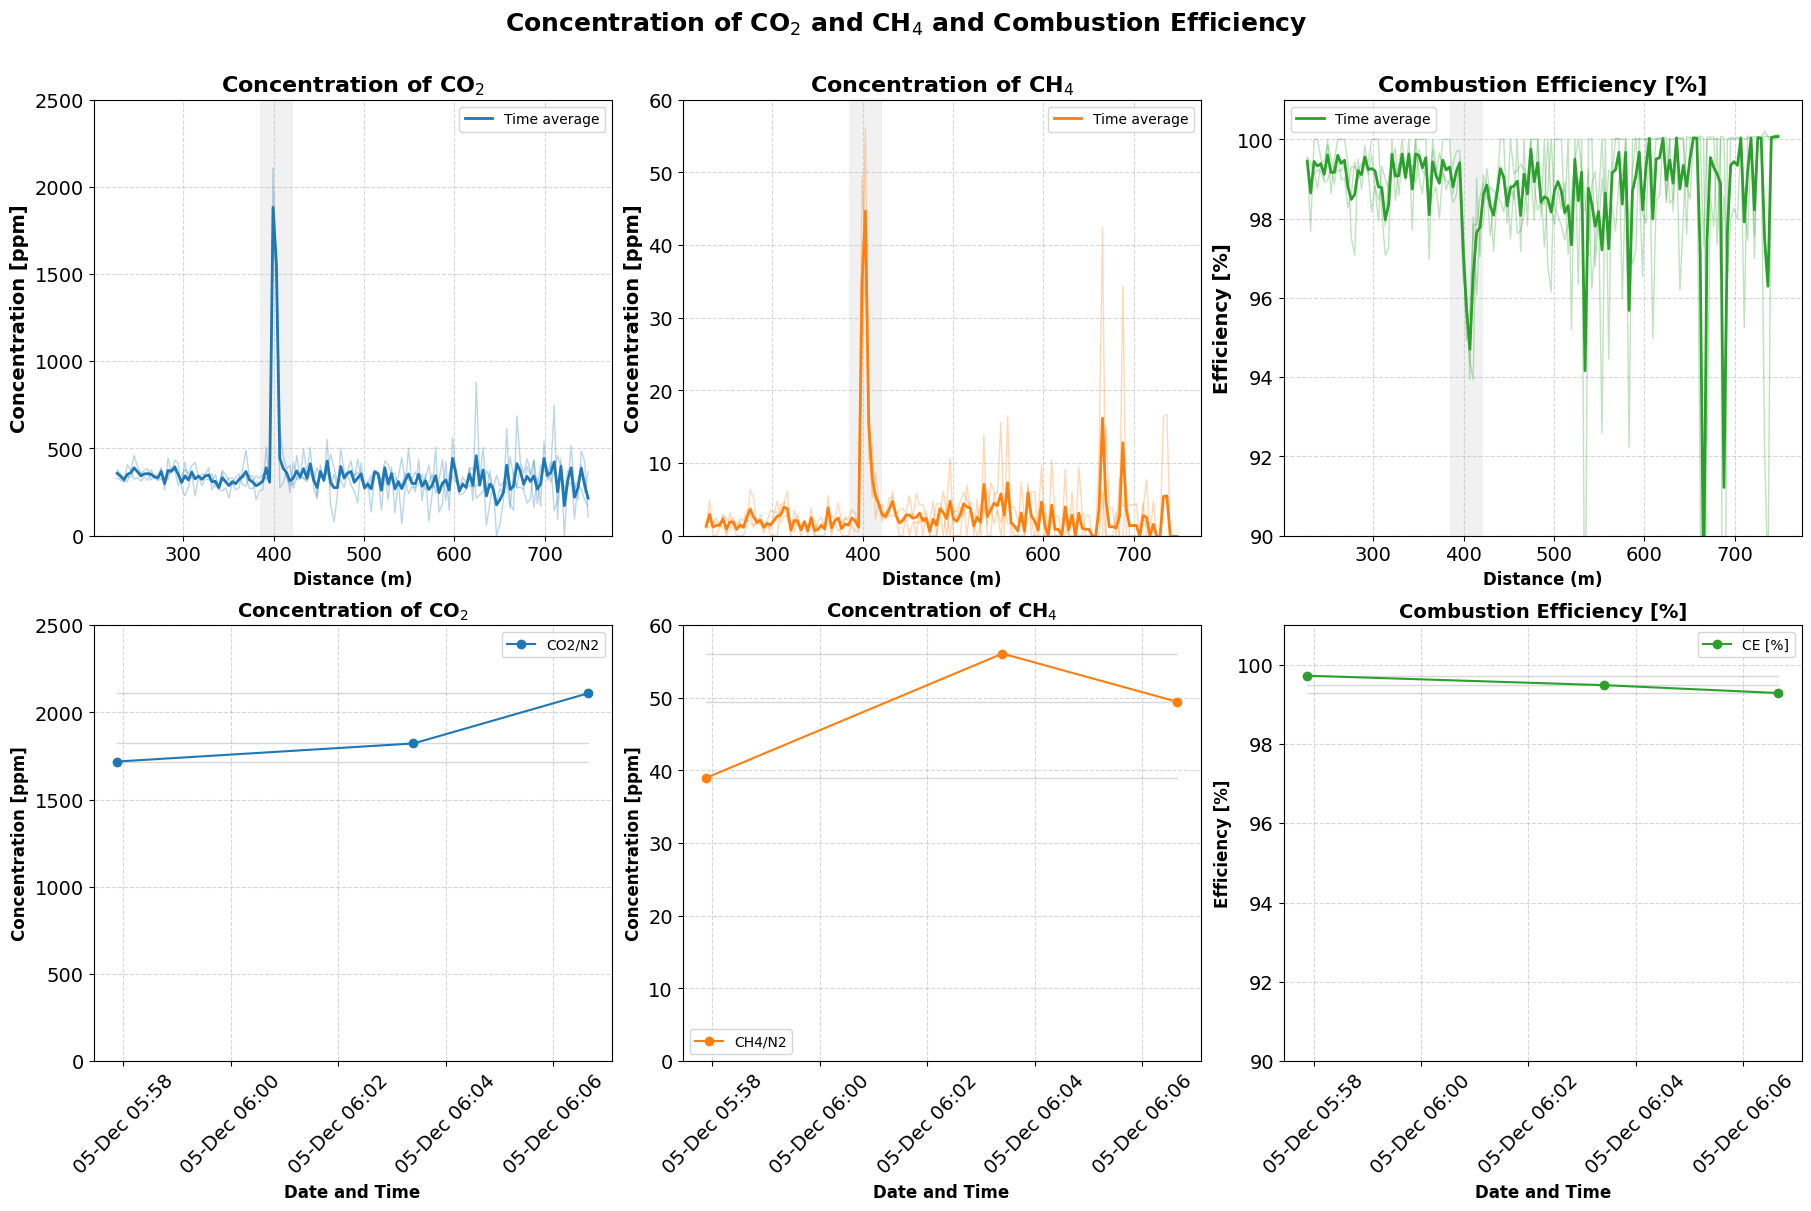

In [43]:
for group_id, res in group_mratios.items():
    file_names = results[group_id]['files']
    file_times_group = [parse_filename_time(f) for f in file_names]
    avg_time = min(file_times_group) + (max(file_times_group) - min(file_times_group)) / 2
    time_labels.append(avg_time)

    z_interval = res['z_interval']
    flare_pos = res['flare_pos']
    mask = (z_interval >= flare_pos - delta) & (z_interval <= flare_pos + delta)

    max_co2.append(np.max(res['mratios']['CO2/N2'][mask]))
    max_ch4.append(np.max(res['mratios']['CH4/N2'][mask]))
    max_ce.append(np.max(res['mratios']['CE [%]'][mask]))

# --- Criar painel 2 linhas x 3 colunas ---
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,12), layout='constrained')
axes = axes.flatten()

# --- Primeira linha: sinais médios vs distância ---
for i, key in enumerate(mean_mratios.keys()):
    ax = axes[i]
    if plot_groups:
        for g in group_mratios.values():
            ax.plot(g['z_interval'], g['mratios'][key],
                    color=colors[key], linestyle='-', alpha=0.3, linewidth=1)
    ax.plot(z_interval_mean, mean_mratios[key],
            color=colors[key], linestyle='-', linewidth=2, label='Time average')
    
    ax.axvspan(flare_pos_mean - delta, flare_pos_mean + delta,
               facecolor='lightgray', alpha=0.3)
    
    ax.set_title(legend_labels[key], fontsize=16, fontweight='bold')
    ax.set_xlabel('Distance (m)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Concentration [ppm]' if key != 'CE [%]' else 'Efficiency [%]',
                  fontsize=14, fontweight='bold')
    ax.set_ylim(ymin_values[key], ymax_values[key])
    ax.tick_params(axis='both', which='major', labelsize=tick_major_size)
    ax.tick_params(axis='both', which='minor', labelsize=tick_minor_size)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=10)

# --- Segunda linha: valores máximos vs tempo com variabilidade ---
max_values_list = [max_co2, max_ch4, max_ce]
variables = ['CO2/N2', 'CH4/N2', 'CE [%]']
ylabels = ['Concentration [ppm]', 'Concentration [ppm]', 'Efficiency [%]']

for i, var in enumerate(variables):
    ax = axes[i+3]  # segunda linha

    # --- Plot individual de cada grupo em cinza com transparência ---
    for g in group_mratios.values():
        z_interval = g['z_interval']
        flare_pos = g['flare_pos']
        mask = (z_interval >= flare_pos - delta) & (z_interval <= flare_pos + delta)
        # plot em cinza apenas os valores máximos dentro do intervalo
        ax.plot(time_labels, [np.max(g['mratios'][var][mask])] * len(time_labels),
                color='gray', linestyle='-', alpha=0.3, linewidth=1)

    # --- Plot do valor máximo em cor sólida ---
    ax.plot(time_labels, max_values_list[i], '-o', color=colors[var], label=var)

    ax.set_title(legend_labels[var], fontsize=14, fontweight='bold')
    ax.set_xlabel('Date and Time', fontsize=12, fontweight='bold')
    ax.set_ylabel(ylabels[i], fontsize=12, fontweight='bold')
    ax.set_ylim(ymin_values[var], ymax_values[var])

    # --- Formatar eixo X ---
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b %H:%M'))
    total_minutes = int((max(time_labels) - min(time_labels)).total_seconds() / 60)
    step = 2 if total_minutes / 2 <= 30 else max(1, total_minutes // 15)
    ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=range(0, 60, step)))

    # --- Tamanho dos ticks ---
    ax.tick_params(axis='both', which='major', labelsize=tick_major_size)
    ax.tick_params(axis='both', which='minor', labelsize=tick_minor_size)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=10)

# --- Título do painel ---
fig.suptitle('Concentration of CO$_2$ and CH$_4$ and Combustion Efficiency\n',
             fontsize=18, fontweight='bold')

plt.show()